# <span style="color:#DC143C">NCF with Side Information (실험 4: Concatenation 차원 전략)</span>
- #### 실험 2의 최적 조합에 대해 임베딩 차원 할당 전략 탐색
* 실험 2에서 선정한 최적 조합 : 케이스4[Item+Category+Author] 0.027467
* 실험 방법
  * 전략 A : 동일 차원(Uniform)
    * Item : 8차원, Category : 8차원, Author : 8차원
  * 전략 B : 차등 차원1(자유 설계)
    * 중요도 기반
      * Item : 16차원, Category: 8차원, Author : 12차원
  * 전략 C : 차등 차원2(자유 설계)
    * 균형 조정
      * Item : 12차원, Category : 10차원, Author: 10차원

* 구글 드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 0. 공통 설정 및 라이브러리 Imports

In [2]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score # 성능 평가
import sys
import warnings; warnings.filterwarnings("ignore")

In [3]:
def set_seed(seed=42):
    """
    실행 결과의 재현성(Reproducibility)을 보장하기 위해 난수 시드를 고정합니다.
    시드를 고정하면 코드를 다시 실행해도 동일한 결과를 얻을 수 있습니다.
    """
    # 1. Python 기본 random 모듈 시드 고정
    random.seed(seed)
    # 2. NumPy 시드 고정
    np.random.seed(seed)
    # 3. PyTorch CPU 연산 시드 고정
    torch.manual_seed(seed)
    # 4. CUDA (GPU) 사용 시 추가 시드 고정 및 설정
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # cuDNN 관련 설정으로, GPU 연산의 비결정성을 줄여줍니다.
        # 연산 속도가 다소 느려질 수 있지만, 재현성을 높여줍니다.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# 전역적으로 시드 고정 (재현성 확보)
SEED = 42
set_seed(SEED)

# 학습/추론에 사용할 디바이스 선택
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 디바이스: {device}")

사용 디바이스: cuda


In [4]:

# --- NCF 모델 구조 관련 ---
GMF_DIM = 8   # 8
MLP_DIM = 8   # 8
MLP_LAYERS = [64, 32, 16, 8]

# --- 학습 관련 ---
BATCH_SIZE = 128
EPOCHS = 20
LR = 1e-4
DROPOUT_RATE = 0.3
PATIENCE = 3

# --- 추천 및 평가 관련 ---
TOP_K = 10
# TEST_USERS = 100

### 1. 데이터 준비

In [5]:
# 학습 데이터 로드 및 기본 정보 확인

# pickle 파일 구조: [train_df, test_df, train_item_meta, test_item_meta]
# - train_df, test_df: USER, ITEM, RATING 컬럼만 포함
# - train_item_meta, test_item_meta: ITEM, category_id, author_id, publisher_id 포함
train_df, test_df, train_item_meta, test_item_meta = pd.read_pickle('/content/drive/MyDrive/4학기/추천시스템/실습-20251011/개인과제/book_train_test_1v3.pkl')

# 전체 데이터 기준으로 M, N 계산 (첫 번째 NCF-pure와 동일한 방식)
all_data = pd.concat([train_df, test_df])
M = all_data['USER'].max() + 1   # Number of users
N = all_data['ITEM'].max() + 1   # Number of items

# Side info 개수도 전체 기준으로 계산: train과 test의 item_meta를 합쳐서 전체 unique 값의 개수를 구함
all_item_meta = pd.concat([train_item_meta, test_item_meta]).drop_duplicates('ITEM')
NUM_CATEGORIES = all_item_meta['category_id'].max() + 1
NUM_AUTHORS = all_item_meta['author_id'].max() + 1
NUM_PUBLISHERS = all_item_meta['publisher_id'].max() + 1

# Side info를 train_df에 병합 및 결측치 처리(혹시 매칭 안 되는 아이템이 있을 경우 0으로 채움)
train_df = train_df.merge(train_item_meta, on='ITEM', how='left')
train_df[['category_id', 'author_id', 'publisher_id']] = train_df[['category_id', 'author_id', 'publisher_id']].fillna(0).astype(int)
train_df = train_df.drop(columns=['publisher_id'])
print(f"총 사용자 수 (M): {M}, 총 아이템 수 (N): {N}")
print(f"카테고리 수: {NUM_CATEGORIES}, 작가 수: {NUM_AUTHORS}")

총 사용자 수 (M): 9057, 총 아이템 수 (N): 26695
카테고리 수: 24, 작가 수: 16640


In [6]:
train_df.head()

,USER,ITEM,RATING,category_id,author_id
0,242,16185,1.0,20,16576
1,242,1586,0.0,7,9121
2,242,8682,0.0,8,7596
3,242,22087,0.0,15,15574
4,2990,23683,1.0,2,7716


In [7]:
# 데이터 준비: NCF Dataset 클래스 정의

class NCFDataset(Dataset):
    """
    NCF 학습을 위한 PyTorch Dataset 클래스
    Side information을 포함합니다
    """
    def __init__(self, df):
        self.users = torch.tensor(df['USER'].values, dtype=torch.long)
        self.items = torch.tensor(df['ITEM'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['RATING'].values, dtype=torch.float32)

        # Side info 추가
        self.categories = torch.tensor(df['category_id'].values, dtype=torch.long)
        self.authors = torch.tensor(df['author_id'].values, dtype=torch.long)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return (self.users[idx], self.items[idx],
                self.categories[idx], self.authors[idx],
                self.ratings[idx])

### 2. NCF 모델 정의

**NCF의 핵심 아이디어:**
- **GMF (Generalized Matrix Factorization)**: 전통적인 Matrix Factorization을 신경망으로 표현
  - 유저 벡터와 아이템 벡터를 **원소별 곱셈(element-wise product)**
  - 선형적인 상호작용 모델링 ("이 유저는 이 아이템과 얼마나 유사한가?")
  
- **MLP (Multi-Layer Perceptron)**: 비선형적 상호작용 학습
  - 유저 벡터와 아이템 벡터를 **연결(concatenation)**한 후 은닉층 통과
  - 복잡한 패턴 모델링 ("유저와 아이템의 잠재적 관계는?")
  
- **NeuMF**: GMF와 MLP의 출력을 결합하여 최종 예측
  - 두 모델의 장점을 모두 활용 (선형 + 비선형)

**왜 두 경로를 결합하는가?**
- GMF만 사용: 표현력 제한 (선형 관계만 포착)
- MLP만 사용: 단순 패턴 포착에 비효율적
- 결합: 단순한 패턴(GMF)과 복잡한 패턴(MLP)을 동시에 학습

In [8]:
class NCF(nn.Module):
    """
    Addition 방식 (GMF): enriched_item = item_emb + author_emb + publisher_emb
    Concatenation 방식 (MLP):
    MLP_input = [user_embedding, item_embedding, category_embedding, author_embedding, publisher_embedding]
    """
    def __init__(self, num_users, num_items, num_categories, num_authors,
                 user_embed_dim, item_embed_dim,  cate_embed_dim, author_embed_dim, mlp_layers):
        super(NCF, self).__init__()

        # --- GMF 경로 (모든 embedding 차원 통일: GMF_DIM) ---
        self.mf_user_embed = nn.Embedding(num_users, GMF_DIM)
        self.mf_item_embed = nn.Embedding(num_items, GMF_DIM)
        self.mf_category_embed = nn.Embedding(num_categories, GMF_DIM)
        self.mf_author_embed = nn.Embedding(num_authors, GMF_DIM)

        # --- MLP 경로 (차원 자유 설정 가능) ---
        self.mlp_user_embed = nn.Embedding(num_users, user_embed_dim)
        self.mlp_item_embed = nn.Embedding(num_items, item_embed_dim)
        self.mlp_category_embed = nn.Embedding(num_categories, cate_embed_dim)
        self.mlp_author_embed = nn.Embedding(num_authors, author_embed_dim)

        # --- MLP 레이어 ---
        mlp_modules = []
        # MLP input size is the concatenation of all MLP embeddings
        input_size = user_embed_dim + item_embed_dim + cate_embed_dim + author_embed_dim
        for layer_size in mlp_layers:
            mlp_modules.append(nn.Linear(input_size, layer_size))
            mlp_modules.append(nn.ReLU())
            mlp_modules.append(nn.Dropout(p=DROPOUT_RATE))
            input_size = layer_size
        self.mlp = nn.Sequential(*mlp_modules)

        # --- 최종 예측 레이어 ---
        final_input_size = GMF_DIM + mlp_layers[-1]
        self.predict_layer = nn.Linear(final_input_size, 1)

        self._init_weights()

    def _init_weights(self):
        """모든 임베딩 레이어 초기화"""
        # GMF embeddings
        nn.init.normal_(self.mf_user_embed.weight, std=0.01)
        nn.init.normal_(self.mf_item_embed.weight, std=0.01)
        nn.init.normal_(self.mf_category_embed.weight, std=0.01)
        nn.init.normal_(self.mf_author_embed.weight, std=0.01)

        # MLP embeddings
        nn.init.normal_(self.mlp_user_embed.weight, std=0.01)
        nn.init.normal_(self.mlp_item_embed.weight, std=0.01)
        nn.init.normal_(self.mlp_category_embed.weight, std=0.01)
        nn.init.normal_(self.mlp_author_embed.weight, std=0.01)



        # Linear layers
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, user_indices, item_indices, category_indices, author_indices):
        """
        Addition 방식 (GMF): enriched_item = item_emb + author_emb + publisher_emb
        Concatenation 방식 (MLP): mlp_input = [user_emb, item_emb, author_emb, publisher_emb]
        """
        # --- GMF 경로 ---
        mf_user = self.mf_user_embed(user_indices)

        # Item + Side Info (Addition) - Note: All GMF embeddings have GMF_DIM
        mf_item_enriched = self.mf_item_embed(item_indices)
        mf_item_enriched = mf_item_enriched + self.mf_category_embed(category_indices)
        mf_item_enriched = mf_item_enriched + self.mf_author_embed(author_indices)

        gmf_output = mf_user * mf_item_enriched

        # --- MLP 경로 (Concatenation) ---
        mlp_user = self.mlp_user_embed(user_indices)
        mlp_parts = [mlp_user, self.mlp_item_embed(item_indices)]

        # side-info 임베딩이 존재할 때마다 concat 후보 리스트에 추가
        mlp_parts.append(self.mlp_category_embed(category_indices))
        mlp_parts.append(self.mlp_author_embed(author_indices))

        mlp_input = torch.cat(mlp_parts, dim=1)
        mlp_output = self.mlp(mlp_input)

        # --- NeuMF 결합 ---
        neumf_input = torch.cat([gmf_output, mlp_output], dim=1)
        logits = self.predict_layer(neumf_input).squeeze(-1)
        return logits

### 3. NCF 모델 학습

In [9]:

def ncf_model_train(user_embed_dim, item_embed_dim, cate_embed_dim, author_embed_dim) :

  print("=== NCF 모델 학습 시작 ===")

  # === NCF 모델 인스턴스 생성 ===
  model = NCF(
      num_users=M,
      num_items=N,
      num_categories=NUM_CATEGORIES,
      num_authors=NUM_AUTHORS,
      user_embed_dim=user_embed_dim,
      item_embed_dim=item_embed_dim,
      cate_embed_dim=cate_embed_dim,
      author_embed_dim=author_embed_dim,
      mlp_layers=MLP_LAYERS
  ).to(device)

  # === 손실 함수 및 옵티마이저 설정 ===
  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-5)

  model.to(device) # 모델을 지정된 디바이스(CPU/GPU)로 이동
  model.train()
  loss_history = []
  best_val_loss = float('inf')
  trigger_times = 0

  # === 데이터 분할 및 재현성 확보 ===
  # 학습/검증(Train/Valid) 데이터 분할: 데이터를 랜덤하게 섞어서 분할합니다.
  # random_state=42를 사용하여 이 분할 과정도 재현성을 보장합니다.
  train_df_shuffled = train_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
  split_idx = int(len(train_df_shuffled) * 0.9) # 90% 학습, 10% 검증
  train_data = train_df_shuffled.iloc[:split_idx]
  valid_data = train_df_shuffled.iloc[split_idx:]

  # DataLoader 생성: 배치 단위로 데이터를 모델에 공급
  # 학습 데이터는 매 Epoch마다 셔플(shuffle=True)하여 학습 다양성을 확보합니다.
  # 드롭아웃 등의 무작위성이 있지만, 전역 시드 설정으로 초기 조건이 고정되어 재현성이 보장됩니다.
  train_loader = DataLoader(NCFDataset(train_data), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
  valid_loader = DataLoader(NCFDataset(valid_data), batch_size=BATCH_SIZE * 2, shuffle=False)

  for epoch in range(EPOCHS):
      # --- Training Loop ---
      total_train_loss = 0
      model.train() # 모델을 학습 모드로 설정 (Dropout 활성화)
      for user_batch, item_batch, cat_batch, author_batch, rating_batch in train_loader:
          # 데이터 디바이스 이동
          user_batch = user_batch.to(device)
          item_batch = item_batch.to(device)
          cat_batch = cat_batch.to(device)
          author_batch = author_batch.to(device)
          rating_batch = rating_batch.to(device)

          # Forward Pass
          logits = model(user_batch, item_batch, cat_batch, author_batch)
          loss = criterion(logits, rating_batch)

          # Backward Pass & Optimizer Step
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          total_train_loss += loss.item()

      avg_train_loss = total_train_loss / len(train_loader)

      # --- Validation Loop ---
      model.eval() # 모델을 평가 모드로 설정 (Dropout 비활성화)
      total_val_loss = 0
      with torch.no_grad():
          for user_val, item_val, cat_val, author_val, rating_val in valid_loader:
              user_val = user_val.to(device)
              item_val = item_val.to(device)
              cat_val = cat_val.to(device)
              author_val = author_val.to(device)
              rating_val = rating_val.to(device)

              logits_val = model(user_val, item_val, cat_val, author_val)
              loss_val = criterion(logits_val, rating_val)
              total_val_loss += loss_val.item()

      avg_val_loss = total_val_loss / len(valid_loader)

      loss_history.append({'loss': avg_train_loss, 'val_loss': avg_val_loss})

      print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_val_loss:.4f}')

      # --- Early Stopping (조기 종료) ---
      # 검증 손실이 더 이상 개선되지 않으면 학습을 조기 종료하여 과적합을 방지합니다.
      if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          trigger_times = 0
      else:
          trigger_times += 1
          if trigger_times >= PATIENCE:
              print(f"Early stopping at epoch {epoch+1} (patience={PATIENCE})")
              break

  # 손실 곡선 시각화
  plt.figure(figsize=(8, 5))
  plt.plot([h['loss'] for h in loss_history], label="Train Loss")
  plt.plot([h['val_loss'] for h in loss_history], label="Validation Loss")
  plt.title("Training Loss History (BCE)")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  return model

### 4. NCF 성능 평가

In [10]:
def performance_predict(model):
  print(f"\n=== 추천 성능 평가 ===")

  # 모델을 평가 모드로 전환 (dropout, batch normalization 등이 비활성화됨)
  model.eval()

  # 평가용: 전체 아이템(0~N-1)의 side info 배열 생성
  # 예: N=10, all_item_meta에 ITEM [5, 7, 9]만 있는 경우
  #     ITEM  category_id  author_id  publisher_id
  #     5          10         100         1000
  #     7          20         200         2000
  #     9          30         300         3000
  meta_indexed = all_item_meta.set_index('ITEM')
  all_cats = meta_indexed['category_id'].reindex(range(N), fill_value=0).values
  # => [0, 0, 0, 0, 0, 10, 0, 20, 0, 30]
  all_authors = meta_indexed['author_id'].reindex(range(N), fill_value=0).values
  all_pubs = meta_indexed['publisher_id'].reindex(range(N), fill_value=0).values

  # 각 지표를 저장할 리스트 초기화
  recalls, precisions, ndcgs = [], [], []

  # 테스트 데이터의 모든 사용자에 대해 반복
  for user_id in test_df['USER'].unique():

      # === Ground Truth 준비 ===
      # 해당 사용자가 실제로 좋아한 아이템들 (RATING=1인 아이템들)을 집합으로 저장
      actual = set(test_df[test_df['USER']==user_id]['ITEM'].values)

      # 만약 사용자가 좋아하는 아이템이 하나도 없으면 평가 불가능하므로 건너뜀
      if len(actual) == 0:
          continue

      # === 모든 아이템에 대한 선호도 점수 예측 ===
      with torch.no_grad():  # 평가 시에는 gradient 계산 불필요 (메모리 절약, 속도 향상)
          # 사용자 ID를 N개(아이템 개수만큼) 복제한 텐서 생성
          # 예: user_id=5이면 [5, 5, 5, ..., 5] (N개)
          user_tensor = torch.full((N,), user_id, dtype=torch.long).to(device)

          # 모든 아이템 ID 생성 [0, 1, 2, ..., N-1]
          item_tensor = torch.arange(N, dtype=torch.long).to(device)

          # Side info 텐서 생성 (미리 만든 리스트 사용)
          cat_tensor = torch.tensor(all_cats, dtype=torch.long).to(device)
          author_tensor = torch.tensor(all_authors, dtype=torch.long).to(device)

          # 모델을 통해 (사용자, 각 아이템) 쌍의 선호도 점수 계산
          logits = model(user_tensor, item_tensor, cat_tensor, author_tensor)

          # Sigmoid 함수를 적용하여 0~1 사이의 확률값으로 변환 후 numpy 배열로 변환
          scores = torch.sigmoid(logits).cpu().numpy()

      # === Top-K 아이템 추출 ===
      # 점수가 높은 순서대로 정렬하여 상위 K개 아이템의 인덱스 추출
      # argsort: 오름차순 정렬된 인덱스 반환 → [-K:]: 뒤에서 K개 → [::-1]: 역순(내림차순)
      top_k_indices = np.argsort(scores)[-TOP_K:][::-1]

      # 추천된 상위 K개 아이템을 집합으로 변환 (교집합 연산을 위해)
      top_k_items = set(top_k_indices)

      # === NDCG (Normalized Discounted Cumulative Gain) 계산 ===
      # DCG 초기화 (순위를 고려한 누적 이득)
      dcg = 0.0

      # 추천된 각 아이템에 대해 순위별로 점수 계산
      for i, item in enumerate(top_k_indices):
          # 추천된 아이템이 실제로 좋아하는 아이템이면
          if item in actual:
              # 상위 순위일수록 높은 가중치 부여
              # log2(i+2)로 나누는 이유: i=0일 때 log2(2)=1, i=1일 때 log2(3)≈1.58...
              # 즉, 순위가 낮을수록 discount (할인) 적용
              dcg += 1.0 / np.log2(i + 2)

      # IDCG (Ideal DCG): 이상적인 경우의 DCG 값
      # 실제로 좋아하는 아이템을 모두 상위 순위에 추천했을 때의 최대 DCG
      # min(len(actual), K): 좋아하는 아이템이 K개보다 적을 수 있으므로
      idcg = sum([1.0 / np.log2(i + 2) for i in range(min(len(actual), TOP_K))])

      # NDCG: DCG를 IDCG로 정규화 (0~1 사이 값, 1에 가까울수록 좋음)
      # IDCG가 0이면 (좋아하는 아이템이 없으면) NDCG도 0
      ndcg = dcg / idcg if idcg > 0 else 0.0
      ndcgs.append(ndcg)

  # === 최종 결과 출력 ===
  # 모든 테스트 사용자에 대한 평균 지표 출력
  # 순위 고려 정확도
  ndcg10 = np.mean(ndcgs)
  return ndcg10

### 5. 임베딩 차원 모델 훈련 및 성능비교



**************************************************
Strategy_A 테스트를 시작합니다.
=== NCF 모델 학습 시작 ===
Epoch [1/20], Train Loss: 0.5781, Valid Loss: 0.5371
Epoch [2/20], Train Loss: 0.5382, Valid Loss: 0.5244
Epoch [3/20], Train Loss: 0.5179, Valid Loss: 0.5280
Epoch [4/20], Train Loss: 0.5042, Valid Loss: 0.5297
Epoch [5/20], Train Loss: 0.4872, Valid Loss: 0.5269
Early stopping at epoch 5 (patience=3)


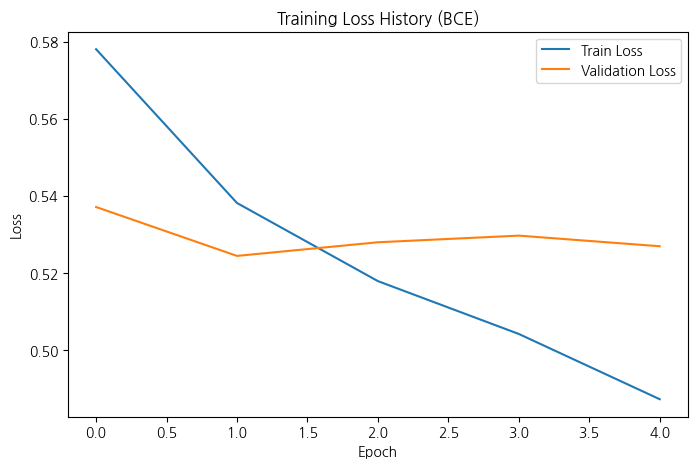


=== 추천 성능 평가 ===
Strategy_A 성능 = NDCG@10 : 0.0252, 파라미터 수: 843,529
**************************************************
Strategy_B 테스트를 시작합니다.
=== NCF 모델 학습 시작 ===
Epoch [1/20], Train Loss: 0.5860, Valid Loss: 0.5377
Epoch [2/20], Train Loss: 0.5439, Valid Loss: 0.5243
Epoch [3/20], Train Loss: 0.5152, Valid Loss: 0.5183
Epoch [4/20], Train Loss: 0.4966, Valid Loss: 0.5149
Epoch [5/20], Train Loss: 0.4803, Valid Loss: 0.5172
Epoch [6/20], Train Loss: 0.4648, Valid Loss: 0.5150
Epoch [7/20], Train Loss: 0.4492, Valid Loss: 0.5157
Early stopping at epoch 7 (patience=3)


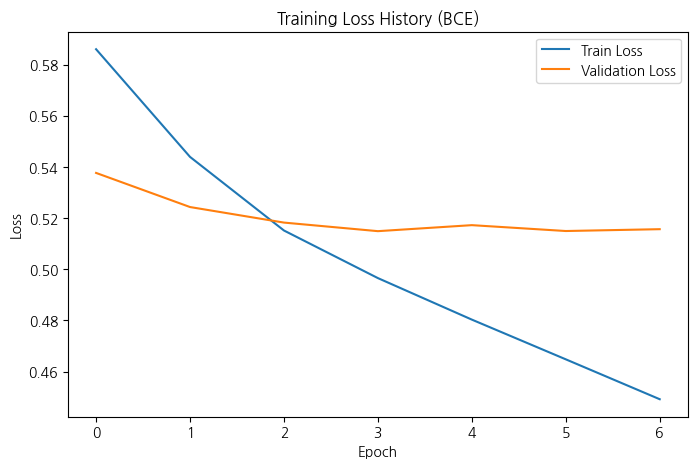


=== 추천 성능 평가 ===
Strategy_B 성능 = NDCG@10 : 0.0232, 파라미터 수: 1,197,385
**************************************************
Strategy_C 테스트를 시작합니다.
=== NCF 모델 학습 시작 ===
Epoch [1/20], Train Loss: 0.5834, Valid Loss: 0.5340
Epoch [2/20], Train Loss: 0.5383, Valid Loss: 0.5212
Epoch [3/20], Train Loss: 0.5149, Valid Loss: 0.5185
Epoch [4/20], Train Loss: 0.4981, Valid Loss: 0.5166
Epoch [5/20], Train Loss: 0.4847, Valid Loss: 0.5185
Epoch [6/20], Train Loss: 0.4711, Valid Loss: 0.5220
Epoch [7/20], Train Loss: 0.4562, Valid Loss: 0.5203
Early stopping at epoch 7 (patience=3)


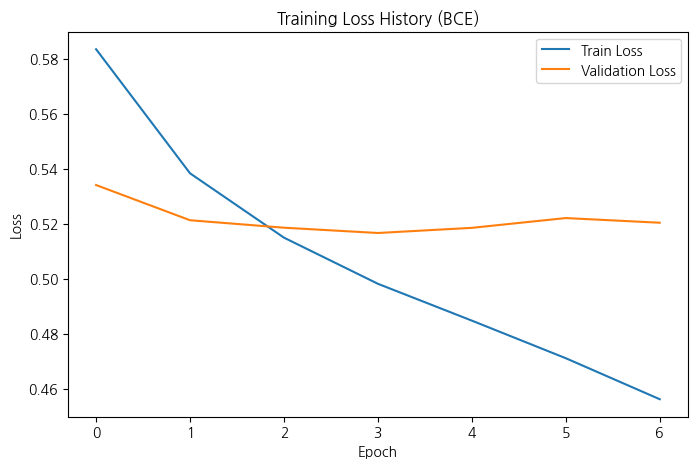


=== 추천 성능 평가 ===
Strategy_C 성능 = NDCG@10 : 0.0218, 파라미터 수: 1,020,633


In [17]:
# 케이스별 설정 목록
strateges = [
    ("Strategy_A",  8, 8, 8, 8),
    ("Strategy_B",  16, 16, 8, 12),
    ("Strategy_C", 12, 12, 10, 10)
]

results = []  # 케이스별 성능 저장 리스트

# 케이스별 실행 루프
for stratege_name, user_embed_dim, item_embed_dim, category_embed_dim, author_embed_dim in strateges:
    print("*" * 50)
    print(f"{stratege_name} 테스트를 시작합니다.")

    # 모델 학습
    ncf_model = ncf_model_train(user_embed_dim, item_embed_dim, category_embed_dim, author_embed_dim)

    # 파라미터 수 계산
    num_params = sum(p.numel() for p in ncf_model.parameters())
    # 성능 평가
    ndcg10 = performance_predict(ncf_model)

    print(f"{stratege_name} 성능 = NDCG@{TOP_K} : {ndcg10:.4f}, 파라미터 수: {num_params:,}")

    # 결과 저장
    results.append({
        "STRATEGY": stratege_name,
        f"NDCG@{TOP_K}": ndcg10,
        "PARAMS": num_params
    })

In [18]:
# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)
results_df["PARAMS_M"] = results_df["PARAMS"] / 1e6  # 백만 단위
results_df["EFFICIENCY"] = results_df[f"NDCG@{TOP_K}"] / results_df["PARAMS_M"]  # 효율지표

# === NDCG 기준으로 내림차순 정렬 ===
results_df = results_df.sort_values(by=f"NDCG@{TOP_K}", ascending=False).reset_index(drop=True)

print("\n" + "=" * 60)
print("📊 전략별 성능 비교표 (내림차순 정렬)")
print("=" * 60)
print(results_df.to_string(index=False))



📊 전략별 성능 비교표 (내림차순 정렬)
  STRATEGY  NDCG@10  PARAMS  PARAMS_M  EFFICIENCY
Strategy_A 0.025250  843529  0.843529    0.029934
Strategy_B 0.023160 1197385  1.197385    0.019342
Strategy_C 0.021828 1020633  1.020633    0.021387


In [19]:
# 한글 폰트 설정 (Colab용)
!apt-get -qq -y install fonts-nanum

In [20]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 폰트 목록 갱신
fontpath = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(fontpath)
plt.rc('font', family='NanumGothic')  # 기본 폰트 변경
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

print("NanumGothic 폰트가 설정되었습니다.")

NanumGothic 폰트가 설정되었습니다.


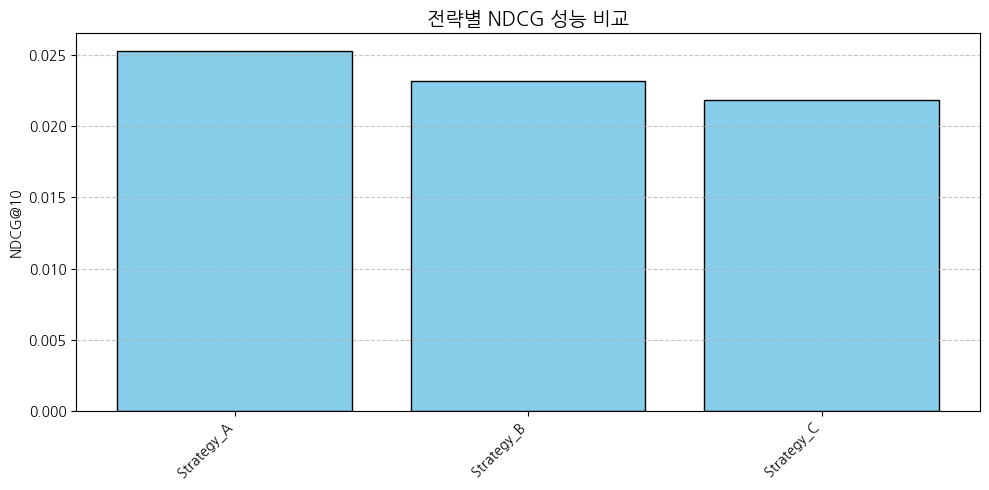

In [21]:
# === 막대그래프 시각화 ===
plt.figure(figsize=(10, 5))
plt.bar(results_df["STRATEGY"], results_df[f"NDCG@{TOP_K}"], color='skyblue', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.ylabel(f"NDCG@{TOP_K}")
plt.title("전략별 NDCG 성능 비교", fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

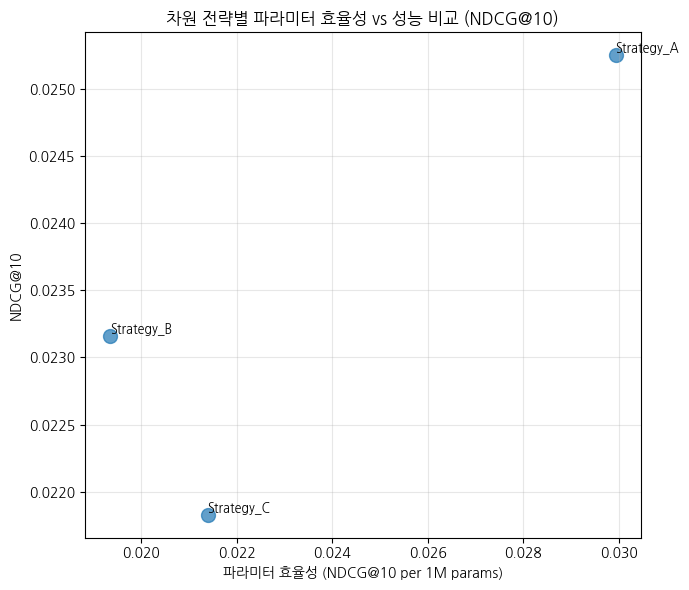

In [22]:
# -----------------------------------------------------------
# 📉 파라미터 효율성(Efficiency) vs 성능(NDCG@10) 그래프
# -----------------------------------------------------------

plt.figure(figsize=(7, 6))

# 산점도: x축=Efficiency, y축=NDCG@10
plt.scatter(results_df["EFFICIENCY"], results_df[f"NDCG@{TOP_K}"], s=100, color="tab:blue", alpha=0.7)

# 각 점에 전략 이름 표시
for i, row in results_df.iterrows():
    plt.text(
        row["EFFICIENCY"], row[f"NDCG@{TOP_K}"],
        row["STRATEGY"],
        fontsize=9, ha="left", va="bottom"
    )

# 축 라벨 및 제목 설정
plt.xlabel("파라미터 효율성 (NDCG@10 per 1M params)")
plt.ylabel(f"NDCG@{TOP_K}")
plt.title(f"차원 전략별 파라미터 효율성 vs 성능 비교 (NDCG@{TOP_K})")

# 그리드 및 레이아웃 정리
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 7. 실험4 결과 분석

* 차등 차원의 효과
  * 전략A는 모든 임베딩 차원을 균등(8, 8, 8) 으로 설정한 단순 구조
  * 전략B와 C는 특정 feature(예: Item, Category 등)에 더 많은 차원을 할당한 차등 전략
  * 관찰 결과
    * 차등 임베딩(전략B, C)은 특정 feature에 집중된 학습을 가능하게 하지만, feature 간 차원의 불균형이 학습 안정성에 영향을 줄 수 있음.
    * 전략B는 Item 차원을 과도하게 확대한 반면, Category 차원이 상대적으로 낮아 모델의 표현 균형이 깨졌을 가능성이 있음.

* 파라미터–성능 Trade-off
  * 파라미터가 늘어나도 성능(NDCG@10)은 A,C간에 유사하나 효율(Efficiency)은 A → C → B 순으로 지속적으로 하락.
  * 전략A – “성능, 효율 극대화 구간”
    * 가장 적은 파라미터로 준수한 성능 확보.
    * 학습 및 추론 효율이 높아 경량형 또는 실시간 추천 환경에 적합.
    * 즉, 성능도 높고 효율성은 최고.
  * 전략B, C – “비효율 구간”
    * 파라미터 수는 많지만, 성능은 오히려 급락.
    * 특정 feature에 차원이 과도하게 집중되어 모델 표현 불균형 및 과적합 가능성.
    * 추가 파라미터가 유효 정보보다 잡음을 더 학습했을 가능성.

* 최적 차원 할당 전략
  * 효율성과 성능을 모두 고려할 때, 전략A (8,8,8)가 가장 합리적
  * 가장 적은 파라미터로 거의 동일한 성능 달성
  * 즉, “모든 feature를 크게 늘리기보다 중요 feature만 부분적으로 확장”하는 방식이 최적.
  
* 결과 분석: 파라미터 효율성 vs 성능 관계
  * 모델이 복잡해질수록 “미세한 성능 향상”을 얻기 위해 “비례 이상으로 많은 파라미터”가 필요함.

* 최종 Concatenation 모델 선정
  * 추천 모델: 전략A (8,8,8)
  * 이유: NDCG@10 성능 손실이 거의 없고, 파라미터 대비 효율이 가장 높음, 과적합 위험이 낮고 학습 안정성 우수.
